In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

For this exercise we will work through the different steps of a linear regression workflow.  We will:

### FSM
1. Load in the dataset: inspect the overall shape, duplicate entries, and na's.
2. Identify the continuous target variable
3. Perform Initial EDA: correlation plots
4. Build a FSM (First Simple Model) with statsmodels/Build a FSM with sklearn
5. Check the assumptions of linear regression  

### Iterate: Build a better model
6. Identify independent variables, and differentiate between numerical vs categorical features
7. Identify and remove outliers  
8. Check for duplicate entries and nas
9. Scale continuous features  
10. Add more continuous features refit, compare R2, check assumptions  

### Iterate: Build a better model
10. Encode categorical variables
11. Add a categorical variable to the model, refit compare R2, check assumptions


## The Dataset
We will use a dataset from [Kaggle](https://www.kaggle.com/kumarajarshi/life-expectancy-who). It contains data collected by the WHO about life expectancy and potentially-related factors.  The information is aggregated on a per-country per-year basis.

The following questions have been posed. Read them and keep them in your mind when building your model.  We will reference them as we proceed through the workflow.

1. Do various predicting factors which have been chosen initially really affect life expectancy? Which predicting variables actually affect life expectancy?
2. Should a country having a lower life expectancy value(<65) increase its healthcare expenditure in order to improve its average lifespan?
3. How do infant and adult mortality rates affect life expectancy?
4. Does life expectancy have positive or negative correlation with eating habits, lifestyle, exercise, smoking, drinking alcohol etc.
5. What is the impact of schooling on the lifespan of humans?
6. Does Life expectancy have positive or negative relationship with drinking alcohol?
7. Do densely populated countries tend to have lower life expectancy?
8. What is the impact of immunization coverage on life Expectancy?

### 1. Load in the dataset and check the overall shape


In [109]:
# load in the dataset
df = None

# How many records are in the data set?
records = None

# How many columns are in the dataset?
columns = None

# Check for duplicate entries

# Check for na's (just look to get an idea; don't drop or impute yet)


### 3. What does a row in the dataframe represent?


In [ ]:
# Your answer here

### 2: Identify the continous target variable

If you had problems isolating that variable, don't worry.  That is on purpose! 
There can be odd, burdensome inconsistencies in naming of data.
Let's use our Python skills to wipe out the naming inconsistencies.

### Clean up the column names. 
There are many ways to do this. One way of doing so, outlined below, uses the columns attribute of the dataframe.  Then, using a list comprehension or for loop, we can manipulate the column name strings using methods that come with the string class.

In [112]:
# 1. Gather column names into a variable
columns = None

# 2. Strip whitespace from the ends
columns = None

# 3. Replace white space with underscores
columns = None

# 4. Make all columns characters lowercase
columns = None

# 5. Reset the column names of the dataframe
# df.columns = columns

In [145]:
df.head()

,life_expectancy,country,year,status,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,65.0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,59.9,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,59.9,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,59.5,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,59.2,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [114]:
# Lastly, to make things easier to interpet, set the target to column index 0


In [117]:
# Revisit the continuous target variable.  
# Explore it a bit.  Plot a histogram of its distribution as well a boxplot

# 3. Perform Initial EDA

There are a lot of variables here!  Let's look at a correlation matrix to see which ones might be the most useful.  (Here we are looking for variables that are highly correlated with the target variable, but not highly correlated with other input variables)

In [120]:
# create a correlation matrix
# first, just use the datafram .corr() method to output a numerical matrix


In [121]:
# Then pass the above code into Seaborn's heatmap plot


In [122]:
# Try adding the code in this cell to the mask attribute in the heatmap to halve the plot
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

In [124]:
# Judging from the correlation matrix or the heatmap, which three features have the highest positive correlation? 


Use seaborn's pairplot function on the three features above plus life_expectancy.  
Note: we would usually start right off by using a pairplot, but because we have so many features, the pairplot would be unwieldy.

In [ ]:
# your code here

Judging from the top row of the pairplot, one feature's correlation to the target is a bit fuzzier than the rest. 
Inspecting other cells of the pairplot, the other two features show covariance. 
Given those two insights, choose one feature to build the First Simple Model with.
Consider also whether choosing one of the positively correlated features above the others would help answer any of the question listed at the beginning of the notebook.


# 4. Build an FSM

## 1. FSM with Statsmodels


In [133]:
from statsmodels.formula.api import ols
# Create a dataframe with only the target and the chosen high-positive corellation feature
fsm_df = None
# For this FSM, simply dropnas.

# build the R-style formula. The format is "target~feature_1 + feature_2 + feature_3"
formula = None

# Fit the model on the dataframe composed of the two features
fsm = ols(formula=formula, data=fsm_df).fit()

In [143]:
# Use the summary() method on the fsm varaible to print out the results of the fit.
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     3599.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:44:43   Log-Likelihood:                -8964.3
No. Observations:                2768   AIC:                         1.793e+04
Df Residuals:                    2766   BIC:                         1.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.1089      0.437    100.992      0.000      43.252      44.965
schooling      2.1035      0.035     59.995      0.000       2.035       2.172
==============================================================================
Omnibus:                      283.391   Durbin-Watson:                   0.267
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1122.013
Skew:                          -0.445   Prob(JB):                    2.28e-244
Kurtosis:                       5.989   Cond. No.                         46.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
# The object also has attributes associated with the ouput, such as: rsquared, and params.
# save those values to the variables below.

rsquared = None
params = None

print(f'Rsquared of FSM: {rsquared}')
print('----------')
print('Beta values of FSM:')
print(params)

Rsquared of FSM: None
----------
Beta values of FSM:
None


Interpret the result of the FSM.  What does the R Squared tell you? Remember the formula for:

$\Large R^2 = 1 - \frac{SSE}{SST}$

Also, interepret the coefficients.  If we increase the value of our independent variable by 1, what does it mean for our predicted value?

What is will our model predict the value of Life Expectancy to be for a country with 0 years of school on average?

In [ ]:
# Your answer here

# 5 Check the assumptions of Linear Regression

### 1. Linearity

#### Linearity

Linear regression assumes that the input variable linearly predicts the output variable.  We already qualitatively checked that with a scatter plot.  But I also think it's a good idea to use a statistical test.  This one is the [Rainbow test](https://www.tandfonline.com/doi/abs/10.1080/03610928208828423) which is available from the [diagnostic submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.linear_rainbow.html#statsmodels.stats.diagnostic.linear_rainbow)

In [167]:
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

rainbow_statistic, rainbow_p_value = linear_rainbow(fsm)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.2910159786411675
Rainbow p-value: 1.057579656507341e-06


The null hypothesis is that the model is linearly predicted by the features, alternative hypothesis is that it is not.  Thus returning a low p-value means that the current model violates the linearity assumption.

#### Normality

Linear regression assumes that the residuals are normally distributed.  It is possible to check this qualitatively with a Q-Q plot.  The fit model object has an attribute called resid, which is an array of the difference between predicted and real values.  Store the residuals in the variable below, show the qq plot, and interepret. You are looking for the theoretical quantiles and the sample quantiles to line up.

In [181]:
# Create a qq-plot

fsm_resids = None

import statsmodels.api as sm
sm.qqplot(fsm_resids)

AttributeError: 'NoneType' object has no attribute 'shape'

Those qqplots don't look so good in the upper right corner.

The [Jarque-Bera](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test) test is performed automatically as part of the model summary output, labeled **Jarque-Bera (JB)** and **Prob(JB)**.

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not.  
What does the JB score output indicate. Does it support the qq-plot?

In [ ]:
# Your answer here

In [ ]:
# Your answer here

#### Homoscadasticity

Linear regression assumes that the variance of the dependent variable is homogeneous across different value of the independent variable(s).  We can visualize this by looking at the predicted life expectancy vs. the residuals.



In [210]:
# Use the predict() method now available to be called from the fsm variable to store the predictions
y_hat = None

# plot y_hat against the residuals (stored in fsm_resids) in a scatter plot



Interepret the result. Do you see any patterns that suggest that the residuals exhibit heteroscedasticity?


Let's also run a statistical test.  The [Breusch-Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) is available from the [diagnostic submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html#statsmodels.stats.diagnostic.het_breuschpagan)

In [220]:
# If you chose schooling, this should run without error
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(fsm_resids, fsm_df[["schooling"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 2.2825932549972298e-67


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.  
What does the p-value returned above indicate?

#### Independence

The independence assumption means that the independent variables must not be too collinear.  Right now we have only one independent variable, so we don't need to check this yet.

In [187]:
fsm_df['life_expectancy']

0       65.0
1       59.9
2       59.9
3       59.5
4       59.2
        ... 
2933    44.3
2934    44.5
2935    44.8
2936    45.3
2937    46.0
Name: life_expectancy, Length: 2768, dtype: float64

In [142]:
fsm.params

Intercept    44.108889
schooling     2.103453
dtype: float64

In [8]:
# Dealing with NA's is often subjective. Let's treat the two columns with the most NA's:
# Population and hepatitis_B

plt.hist(df.hepatitis_b)
np.return_counts(df.hepatitis_b

SyntaxError: unexpected EOF while parsing (<ipython-input-8-7e27295f03d4>, line 5)

In [47]:
# How many numerical target variables are there



In [1]:
X = ames.drop(['SalePrice', 'Order', 'PID' ], axis=1)
X = sm.add_constant(X)
X = X.select_dtypes(exclude='object')
X = X.dropna()
y = ames['SalePrice']
y = y.iloc[X.index]
X.sample(5)

NameError: name 'ames' is not defined

In [31]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     346.5
Date:                Sun, 07 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:41:16   Log-Likelihood:                -26906.
No. Observations:                2274   AIC:                         5.388e+04
Df Residuals:                    2239   BIC:                         5.408e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.973e+05    1.1e+06      0.271      0.786   -1.85e+06    2.45e+06
MS SubClass      -181.2888     21.738     -8.340      0.000    -223.918    -138.660
Lot Frontage      -86.1443     41.550     -2.073      0.038    -167.625      -4.664
Lot Area            0.6074      0.130      4.679      0.000       0.353       0.862
Overall Qual      1.84e+04    892.124     20.627      0.000    1.67e+04    2.02e+04
Overall Cond     4229.4436    849.907      4.976      0.000    2562.756    5896.131
Year Built        304.4727     55.514      5.485      0.000     195.609     413.337
Year Remod/Add    169.6601     53.641      3.163      0.002      64.468     274.852
Mas Vnr Area       36.5697      4.668      7.834      0.000      27.415      45.724
BsmtFin SF 1       12.9009      1.908      6.761      0.000       9.159      16.643
BsmtFin SF 2        3.5412      3.393      1.044      0.297      -3.113      10.196
Bsmt Unf SF        -3.9065      1.826     -2.139      0.033      -7.488      -0.325
Total Bsmt SF      12.5356      2.574      4.870      0.000       7.488      17.583
1st Flr SF         20.1710      5.082      3.969      0.000      10.205      30.137
2nd Flr SF         18.6415      4.658      4.002      0.000       9.506      27.777
Low Qual Fin SF    -4.9244     12.559     -0.392      0.695     -29.552      19.703
Gr Liv Area        33.8881      4.757      7.125      0.000      24.560      43.216
Bsmt Full Bath   6251.0807   2002.352      3.122      0.002    2324.420    1.02e+04
Bsmt Half Bath  -2479.9092   3166.237     -0.783      0.434   -8688.977    3729.158
Full Bath        2687.8561   2205.099      1.219      0.223   -1636.396    7012.108
Half Bath         507.5701   2105.471      0.241      0.810   -3621.310    4636.450
Bedroom AbvGr   -7915.1212   1349.422     -5.866      0.000   -1.06e+04   -5268.871
Kitchen AbvGr   -2.122e+04   4541.203     -4.673      0.000   -3.01e+04   -1.23e+04
TotRms AbvGrd    3287.8511    945.658      3.477      0.001    1433.392    5142.310
Fireplaces       3400.5936   1362.866      2.495      0.013     727.980    6073.207
Garage Yr Blt     -22.2748     58.579     -0.380      0.704    -137.149      92.600
Garage Cars      9963.1130   2248.075      4.432      0.000    5554.583    1.44e+04
Garage Area        23.4529      7.765      3.020      0.003       8.225      38.681
Wood Deck SF       19.4684      6.373      3.055      0.002       6.971      31.965
Open Porch SF     -14.2139     12.053     -1.179      0.238     -37.850       9.422
Enclosed Porch     18.1280     12.318      1.472      0.141      -6.028      42.284
3Ssn Porch         18.6668     28.175      0.663      0.508     -36.585      73.918
Screen Porch       64.5210     12.681      5.088      0.000      39.654      89.388
Pool Area         -60.6334     19.955     -3.039      0.002

In [33]:
# Resources
# https://planspace.org/20150423-forward_selection_with_statsmodels/

In [34]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [38]:
import statsmodels.formula.api as smf
data = X
data['target'] = y
forward_selected(X, 'target')

SyntaxError: invalid syntax (<unknown>, line 1)

In [41]:
data.columns

Index(['const', 'MS SubClass', 'Lot Frontage', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'target'],
      dtype='object')

In [ ]:
# Describe Shape
# Investigate meaning of column names
# From your intuition, what do you think is going to have the greatest effect on house price
# address NA's
# plot histograms and boxplots
# remove outliers
# scale
# Run baseline models and make sure that statsmodels and sklearn return the same R2
# plot a QQ plot
# plot residuals to check for homoscedasticity


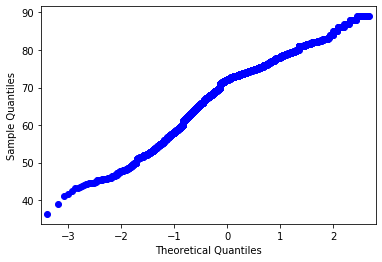

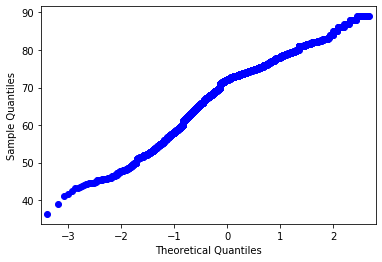

In [36]:
import statsmodels.api as sm
sm.qqplot(df['life_expectancy'])

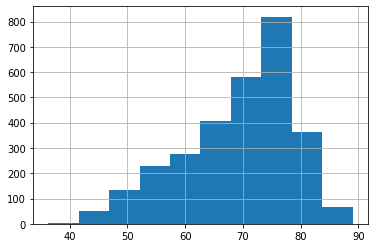

In [37]:
df['life_expectancy'].hist()

In [41]:
x = sorted(df['life_expectancy'])
len(x)

2938